# GLORIA OOD

In [9]:
# imports
import numpy as np
from importlib import reload

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from datetime import datetime, time
import random 

import pandas
import seaborn as sns

from scipy.spatial import Delaunay
from sklearn import decomposition

from oceancolor.hydrolight import loisel23
from oceancolor.insitu import gloria
from oceancolor.utils import spectra

In [2]:
%matplotlib ipympl

# Load up

## GLORIA

In [3]:
reload(gloria)
df_meta, df_Rrs, df_Rrs_std, df_qc_flags = gloria.load_gloria()

Loading GLORIA dataset...


In [4]:
gloria_wv, gloria_Rrs, _ = gloria.parse_table(df_Rrs, 'Rrs')
_, gloria_Rrs_std, _ = gloria.parse_table(df_Rrs_std, 'Rrs_std')

## L23

In [5]:
X,Y = 4,0
l23_ds = loisel23.load_ds(X, Y)

# Wavelengths, restricted to > 400 nm
#cut = (l23_ds.Lambda > min_wv) & (l23_ds.Lambda < high_cut)
l23_a = l23_ds.a.data[:]
l23_wave = l23_ds.Lambda.data

l23_Rs = l23_ds.Rrs.data[:]

# Rebin/cut GLORIA to L23

In [6]:
new_gloria_wv = np.append(l23_wave, [l23_wave.max()+5.]) - 2.5 # Because the rebinning is not interpolation
#
rwv_nm, gloria_rebin, gloria_rebin_sig = spectra.rebin_to_grid(gloria_wv, gloria_Rrs, gloria_Rrs_std, new_gloria_wv)

/home/xavier/Projects/Oceanography/python/ocean-color/oceancolor/utils/spectra.py:66: RuntimeWarning: invalid value encountered in divide
  isum = np.nansum(values[gd]*mask[gd], axis=0) / mask_sum
/home/xavier/Projects/Oceanography/python/ocean-color/oceancolor/utils/spectra.py:67: RuntimeWarning: invalid value encountered in divide
  esum = np.nansum(err_vals[gd]*mask[gd], axis=0) / mask_sum


## Clean up

In [13]:
bad_Rs = np.where(np.isnan(gloria_rebin))

In [14]:
keep_gloria = np.ones(gloria_rebin.shape[0], dtype=bool)
bad_rows = np.unique(bad_Rs[0])
keep_gloria[bad_rows] = False

In [7]:
l23_Rs.shape

(3320, 81)

# PCA

In [10]:
pca_fit = decomposition.PCA(n_components=5).fit(l23_Rs)

## Decompose

In [11]:
l23_coeff = pca_fit.transform(l23_Rs)
l23_coeff.shape

(3320, 5)

In [15]:
gloria_coeff = pca_fit.transform(gloria_rebin[keep_gloria])

In [16]:
gloria_coeff.shape

(1957, 5)

# Delaunay Hull

## Build the hull

In [43]:
hull = Delaunay(l23_coeff)

## Query Gloria

In [44]:
gloria_hull = hull.find_simplex(gloria_coeff)
in_hull = gloria_hull >= 0

In [45]:
np.sum(in_hull)

44

In [46]:
idx_keep = np.where(keep_gloria)[0]
idx_in = np.where(in_hull)[0]
idx_keep[idx_in]

array([1354, 1355, 1565, 1567, 1568, 1572, 1603, 1624, 1629, 1632, 1636,
       1723, 2002, 2011, 2236, 2283, 2284, 2317, 2382, 2386, 2387, 2397,
       2398, 2403, 2404, 2431, 2432, 2455, 2456, 2461, 2462, 2464, 2465,
       4282, 4292, 4294, 4295, 4298, 4299, 4316, 4317, 4318, 4321, 4322])

# Examine

## Consider closest to one in the hull

In [47]:
ii = idx_in[0]
gloria_hull[ii]

9867

In [49]:
hull.simplices[gloria_hull[ii]]

array([ 752,   32,  826, 1167,  841, 2298], dtype=int32)

## Plots

In [51]:
mean_l23 = np.mean(l23_Rs, axis=0)
mean_l23.shape

(81,)

In [28]:
gloria_rebin.shape

(7572, 81)

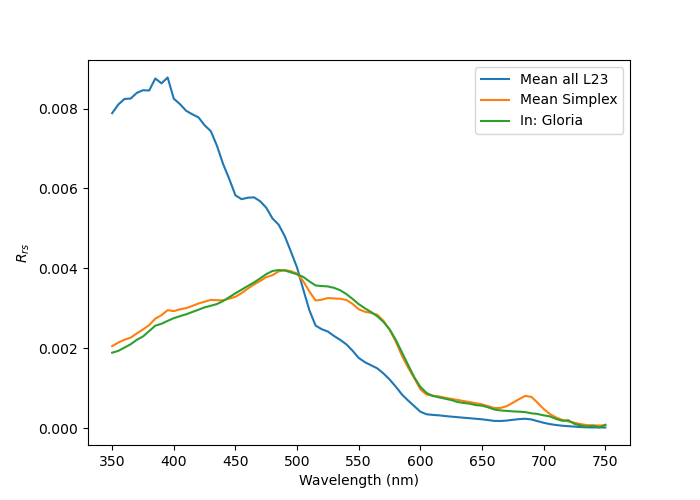

In [55]:
#idx = 1354
ii = 0
idx = idx_keep[idx_in[ii]]

# Generate Rs of the simplex
vertices = hull.simplices[gloria_hull[idx_in[ii]]]
s_Rrs = l23_Rs[vertices]
mean_s = np.mean(s_Rrs, axis=0)

fig = plt.figure(figsize=(7,5))

plt.clf()
ax = plt.gca()
ax.plot(l23_wave, mean_l23, label='Mean all L23')
ax.plot(l23_wave, mean_s, label='Mean Simplex')
ax.plot(rwv_nm, gloria_rebin[idx,:], label='In: Gloria')
#
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel(r'$R_{rs}$')
ax.legend()
#
plt.show()

## Out

In [33]:
idx_out = np.where(~in_hull)[0]
idx_keep[idx_out]


array([   0,    1,    2, ..., 7250, 7251, 7252])

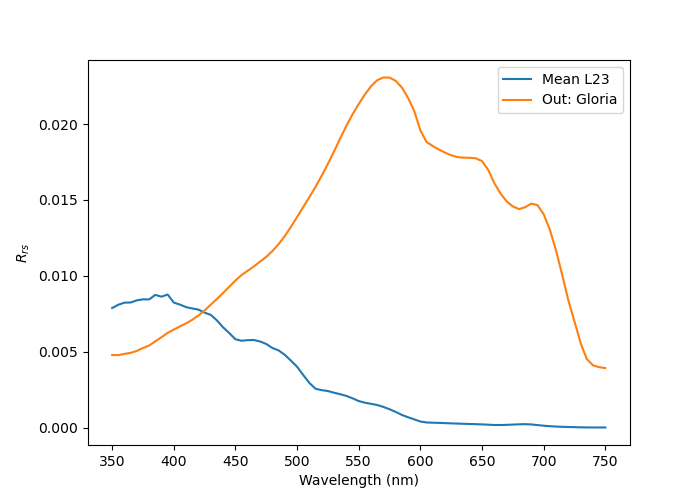

In [37]:
idx = 7250

fig = plt.figure(figsize=(7,5))

plt.clf()
ax = plt.gca()
ax.plot(l23_wave, mean_l23, label='Mean L23')
ax.plot(rwv_nm, gloria_rebin[idx,:], label='Out: Gloria')
#
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel(r'$R_{rs}$')
ax.legend()
#
plt.show()